Enfoque del dataset de noticias falsas basado en BiLSTM (CNN)

In [10]:
### IMPORTS ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cargar Dataset

In [2]:
### DRIVE DATA ###
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
PATH = "/content/drive/My Drive/TFM/Data/FakeNews_Task3_2022/"

Mounted at /content/drive


In [3]:
### CONJUNTOS DE ENTRENAMIENTO, VALIDACIÓN Y TEST ###
df_train = pd.read_csv(PATH + "Task3_train_dev/Task3_english_training.csv") 
df_train = df_train[['text', 'our rating']]
df_train = df_train.rename(columns = {"text": "Text", "our rating": "Label"})

df_dev = pd.read_csv(PATH + "Task3_train_dev/Task3_english_dev.csv") 
df_dev = df_dev[['text', 'our ratinge']]
df_dev = df_dev.rename(columns = {"text": "Text", "our ratinge": "Label"})

df_test = pd.read_csv(PATH + "Task3_Test/English_data_test_release_with_rating.csv") 
df_test = df_test[['text', 'our rating']]
df_test = df_test.rename(columns = {"text": "Text", "our rating": "Label"})

print('Tamaño Conjunto de Entrenamiento:', len(df_train['Label']))
print('Tamaño Conjunto de Validación:', len(df_dev['Label']))
print('Tamaño Conjunto de Evaluación:', len(df_test['Label']))

Tamaño Conjunto de Entrenamiento: 900
Tamaño Conjunto de Validación: 364
Tamaño Conjunto de Evaluación: 612


# Label Encoding

In [4]:
### LABEL ENCODING ###
y_train = df_train['Label'].tolist()
y_val = df_dev['Label'].tolist()
y_test = df_test['Label'].tolist()

LABELS = sorted(set(y_train))
NUM_LABELS = len(LABELS)

idx2label={}
label2idx={}
for index, label in enumerate(LABELS):
    label2idx.update([(label, index)])
    idx2label.update([(index, label)])

print('Labels:', label2idx)
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_train_cat = to_categorical(y_train)
y_val = le.fit_transform(y_val)
y_val_cat = to_categorical(y_val)
y_test = le.fit_transform(y_test)
y_test_cat = to_categorical(y_test)

Labels: {'False': 0, 'Other': 1, 'Partially false': 2, 'True': 3}


# Tokenización

In [5]:
X_train = list(df_train['Text'])
X_val = list(df_dev['Text'])
X_test = list(df_test['Text'])

tokenizer = Tokenizer(oov_token = True)
# entrenamos el tokenizador usando los textos del conjunto de entrenamiento
tokenizer.fit_on_texts(X_train)

# el índice 0, en principio, no ha sido asignado a ningún token y está reservado
# en nuestro caso, lo usamos para representar el token para padding
tokenizer.word_index[''] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario = {}".format(NUM_WORDS))

encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_val = tokenizer.texts_to_sequences(X_val)
encoded_test = tokenizer.texts_to_sequences(X_test)

Tamaño del vocabulario = 33432


In [6]:
# Análisis de Longitud #
df_train['Length'] = df_train['Text'].apply(lambda text: len(text.split()))
df_train['Length'].describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count     900.000000
mean      685.137778
std       764.336155
min         4.000000
25%       276.750000
50%       492.500000
75%       806.750000
90%      1289.300000
95%      2070.350000
99%      4752.990000
max      5816.000000
Name: Length, dtype: float64

In [7]:
MAX_LEN = 2071

encoded_train = pad_sequences(encoded_train, maxlen = MAX_LEN, padding='post')
encoded_val = pad_sequences(encoded_val, maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

# CNN

In [8]:
EMBEDDING_SIZE=200
model = Sequential()

model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_LABELS, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Stop training when a monitored quantity has stopped improving.
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2071, 200)         6686400   
                                                                 
 conv1d (Conv1D)             (None, 2071, 128)         102528    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1035, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1035, 64)          24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 517, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 517, 32)           4

Training:

In [9]:
# Entrenamos el modelo
epochs = 20 # número de veces que pasamos sobre el conjunto de aprendizaje

#número de ejemplos que procesamos antes de acutalizar los pesos
batch_size = 16 

# training
history=model.fit(encoded_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val_cat), callbacks=[earlyStopping])


Epoch 1/20
57/57 [==============================] - 46s 776ms/step - loss: 1.2376 - accuracy: 0.4967 - val_loss: 1.3872 - val_accuracy: 0.3132
Epoch 2/20
57/57 [==============================] - 42s 746ms/step - loss: 1.0556 - accuracy: 0.5500 - val_loss: 1.1259 - val_accuracy: 0.4835
Epoch 3/20
57/57 [==============================] - 44s 775ms/step - loss: 0.5786 - accuracy: 0.7744 - val_loss: 1.0544 - val_accuracy: 0.5824
Epoch 4/20
57/57 [==============================] - 42s 735ms/step - loss: 0.2311 - accuracy: 0.9233 - val_loss: 1.5091 - val_accuracy: 0.5220
Epoch 5/20
57/57 [==============================] - 43s 751ms/step - loss: 0.1222 - accuracy: 0.9611 - val_loss: 1.5279 - val_accuracy: 0.5385
Epoch 6/20
57/57 [==============================] - 43s 750ms/step - loss: 0.0784 - accuracy: 0.9844 - val_loss: 2.0025 - val_accuracy: 0.5220


Curvas de Aprendizaje:

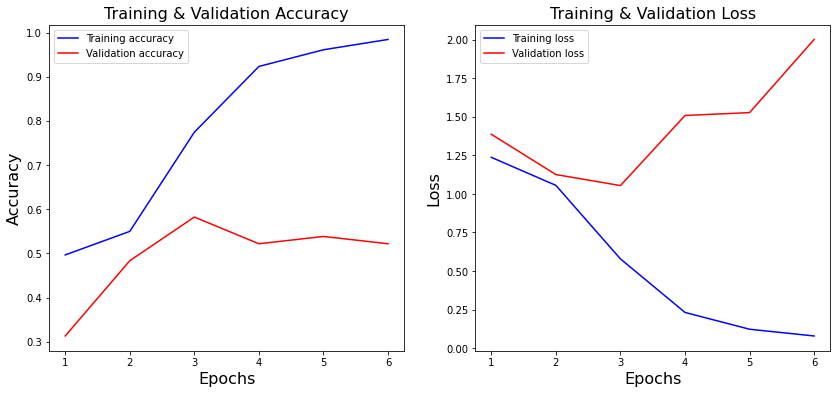

In [11]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Evaluación:

20/20 [==============================] - 9s 448ms/step
accuracy: 0.4673202614379085
              precision    recall  f1-score   support

           0       0.57      0.81      0.67       315
           1       0.13      0.10      0.11        31
           2       0.11      0.20      0.14        56
           3       0.44      0.08      0.13       210

    accuracy                           0.47       612
   macro avg       0.31      0.30      0.26       612
weighted avg       0.46      0.47      0.41       612

[[256   7  38  14]
 [ 24   3   2   2]
 [ 37   4  11   4]
 [133   9  52  16]]


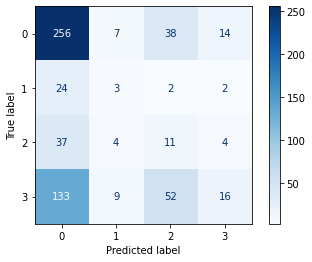

In [12]:
loss, accuracy = model.evaluate(encoded_test, y_test_cat, batch_size=batch_size)

y_pred = np.argmax(model.predict(encoded_test), axis=1)
print('accuracy:', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=['0','1','2','3']))

cm = confusion_matrix(y_test, y_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1','2','3'])
disp.plot(cmap=plt.cm.Blues,values_format='g')